In [12]:
# %matplotlib widget
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os

os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
from analysis_pkg.models import *
from analysis_pkg.adptive_lasso import LinearInteractionModel
from PCA_TSNE_scoremodel.visualization import *
from llm_belief.analysis import visualize_probability_distribution
ScoreModel = 'LogitSquareScore'  # 'MLPAttentionScore'  #'LogisticRegression' #'MLPScore'
flag_interaction = True  # 是否使用交互项
flag_square = True  # 是否使用平方项
sufix = f"{'interaction' if flag_interaction else 'no_interaction'}_{'squared' if flag_square else 'no_square'}"
score_col_name = f"adplasso{'_interaction' if flag_interaction else ''}{'_square' if flag_square else ''}"
torch.manual_seed(2025)

In [13]:
# ==== 2) load data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [14]:
# ==== 3) preprocess data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

In [15]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

model = LinearInteractionModel(
    in_dim=d,
    include_interaction=flag_interaction,   # 是否加入交互项
    include_squares=flag_square       # 是否加入平方项
)

In [16]:
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")

[Epoch 01] train_loss=0.6798  val_loss=0.6131
[Epoch 02] train_loss=0.5686  val_loss=0.5485
[Epoch 03] train_loss=0.5150  val_loss=0.5112
[Epoch 04] train_loss=0.4811  val_loss=0.4844
[Epoch 05] train_loss=0.4567  val_loss=0.4643
[Epoch 06] train_loss=0.4382  val_loss=0.4486
[Epoch 07] train_loss=0.4237  val_loss=0.4365
[Epoch 08] train_loss=0.4122  val_loss=0.4267
[Epoch 09] train_loss=0.4031  val_loss=0.4190
[Epoch 10] train_loss=0.3959  val_loss=0.4128
[Epoch 11] train_loss=0.3898  val_loss=0.4081
[Epoch 12] train_loss=0.3851  val_loss=0.4040
[Epoch 13] train_loss=0.3813  val_loss=0.4011
[Epoch 14] train_loss=0.3782  val_loss=0.3986
[Epoch 15] train_loss=0.3757  val_loss=0.3963
[Epoch 16] train_loss=0.3735  val_loss=0.3951
[Epoch 17] train_loss=0.3718  val_loss=0.3935
[Epoch 18] train_loss=0.3706  val_loss=0.3923
[Epoch 19] train_loss=0.3692  val_loss=0.3918
[Epoch 20] train_loss=0.3686  val_loss=0.3914
Calibrated Temperature T = 0.920


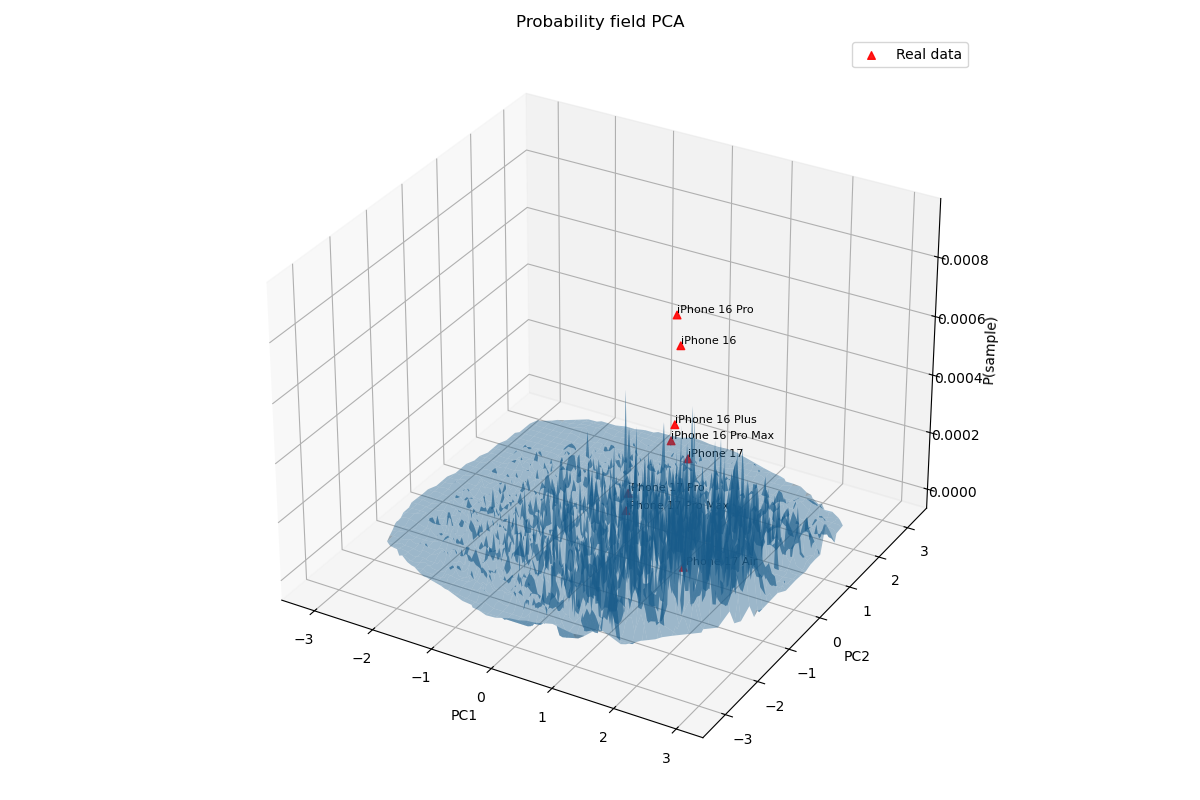

In [17]:
# ==== 6) test on real profiles ====
df_real = pd.read_csv("../data/real_profiles.csv")
X_test = df_real[profiles.columns]
X_test = preprocess_test(X_test)
test_idx = df_real["real model"].tolist()
_, probs, scores = visualize_probability_distribution(
    model, torch.cat([X, X_test], dim=0), T, num_test=X_test.shape[0], test_idx=test_idx, fig_name=f"3d_plot_8_PCA_{ScoreModel}_{sufix}.png",
)

In [18]:
# ==== score all profiles and save ====
scored_df = pd.read_csv("../data/scored_profiles_shuffled.csv")
real_scored_df = pd.read_csv("../data/scored_real_profiles.csv")
X_all = preprocess_test(scored_df.iloc[:,:10])
all_scores, all_probs = score_profiles(model, X_all, T=T)
scored_df['LogitSquare'] = all_scores

X_real = preprocess_test(real_scored_df.iloc[:,:10])
real_scores, real_probs = score_profiles(model, X_real, T=T)
real_scored_df['LogitSquare'] = real_scores
scored_df.to_csv(f"../data/scored_profiles_shuffled.csv", index=False)
real_scored_df.to_csv(f"../data/scored_real_profiles.csv", index=False)